<table>
    <tr>
        <td><img src="./imagenes/Macc.png" width="400"/></td>
        <td>&nbsp;</td>
        <td>
            <h1 style="color:blue;text-align:left">Inteligencia Artificial</h1></td>
        <td>
            <table><tr>
            <tp><p style="font-size:150%;text-align:center">Notebook</p></tp>
            <tp><p style="font-size:150%;text-align:center">Arquitecturas de agente</p></tp>
            </tr></table>
        </td>
    </tr>
</table>

---


## Objetivo <a class="anchor" id="inicio"></a>

En este notebook ejemplificaremos dos tipos de agente: dirigido por tabla y de respuesta simple. Usaremos el problema del laberinto para implementar los programa de agente y mostraremos una manera de comparar sus desempeños.


[Ir al ejercicio 1](#ej1)

## Dependencias

Al iniciar el notebook o reiniciar el kerner se pueden cargar todas las dependencias de este notebook corriendo las siguientes celdas. Este también es el lugar para instalar las dependencias que podrían hacer falta.

In [4]:
pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spyder 5.1.5 requires pyqt5<5.13, which is not installed.
spyder 5.1.5 requires pyqtwebengine<5.13, which is not installed.
daal4py 2021.5.0 requires daal==2021.4.0, which is not installed.
scipy 1.7.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.24.2 which is incompatible.
numba 0.55.1 requires numpy<1.22,>=1.18, but you have numpy 1.24.2 which is incompatible.
ipykernel 6.9.1 requires ipython>=7.23.1, but you have ipython 7.19.0 which is incompatible.


**De Python:**

In [5]:
import numpy as np

**Del notebook:**

In [7]:
from agentes import Random, TableDriven, RuleBased
from ambientes import Laberinto
import utils

%reload_ext autoreload
%autoreload 2

## Secciones

Desarrollaremos la explicación en las siguientes secciones:

1. [El ambiente del laberinto](#lab)
2. [Un agente dirigido por tabla](#agenteTD)
3. [Un agente de reflejo simple](#agenteSR)
4. [Pruebas de desempeño](#pruebas)

## El ambiente del laberinto <a class="anchor" id="lab"></a>

([Volver al inicio](#inicio))

Imagine un agente dentro de un laberinto, el cual consiste de una rejilla de doce por doce casillas. El laberinto tiene solo una casilla que sirve de entrada y de salida, que es la casilla $(0,0)$. Observe que en la notación de las casillas, la primera coordenada representa la posición en el ejer horizontal y la segunda en el vertical, con origen la esquina inferior izquierda. Esta casilla es la única forma de salir o entrar al laberinto. Cada rejilla es o bien un pasadizo o bien un muro. El agente puede moverse una casilla en dirección vertical u horizontal (nunca diagonal) siempre y cuando la casilla a la que se mueve no sea un muro o el fin de la rejilla. El problema que debe resolver el agente es encontrar un camino que lo lleve hasta la salida.

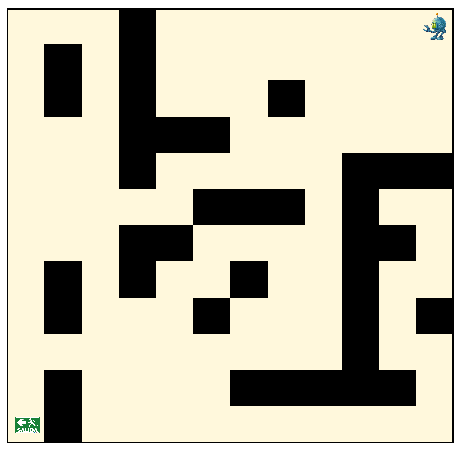

In [8]:
lab = Laberinto()
lab.render()

La percepción del agente consiste en una colección de sensores que se encienden cuando detectan un obstáculo, organizados de la siguiente manera:

`[sensor frontal, sensor izquierdo, sensor derecho, sensor trasero]`

Los estados del `Laberinto` los constituyen los valores de los sensores:

In [9]:
lab = Laberinto()
state = lab.reset()
print('El estado inicial es:')
print(f'[sensor frontal={state[0]}, sensor izquierdo={state[1]}, sensor derecho={state[2]}, sensor trasero={state[3]}]')

El estado inicial es:
[sensor frontal=False, sensor izquierdo=False, sensor derecho=True, sensor trasero=True]


Las acciones posibles del agente son:

* adelante: el agente avanza una casilla.
* voltearIzquierda: el agente gira 90º en contra de las manecillas del reloj.
* voltearDerecha: el agente gira 90º a favor de las manecillas del reloj.

Cada acción del agente tiene un efecto en el entorno, implementado mediante el método `step(action)` de la clase `Laberinto`. Este método recibe la acción del agente y devuelve un nuevo estado, una recompensa, y la información de si el entorno sigue activo. Este es el ciclo básico agente-entorno, ejemplificado en el siguiente diagrama:

<img src="./imagenes/agent_loop.png" width="400"/>

En el módulo `utils` tenemos una serie de clases que nos harán la vida más fácil a la hora de correr los agentes en el entorno. La colección de rondas desde el estado inicial hasta el estado final o hasta el número máximo de rondas se llama un **episodio**. La clase que usaremos para correr un episodio se llama `Episode`. Veamos un ejemplo en donde un agente aleatorio, implementado en la clase `Random` del módulo `agentes`, parte de la casilla $(11,11)$ y deambula aleatoriamente por el laberinto por 15 rondas:

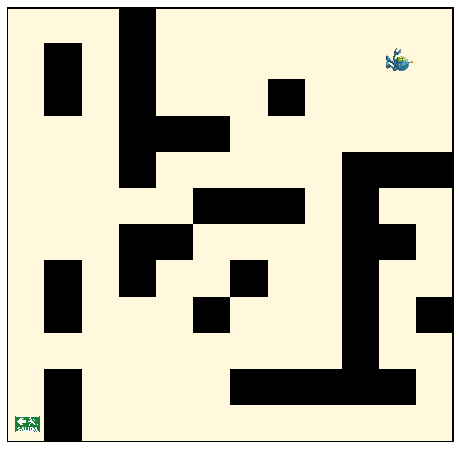

In [13]:
# Create environment
lab = Laberinto()
# Create agent
agent = Random()
# Create episode
episodio = utils.Episode(environment=lab,\
        agent=agent,\
        model_name='Random',\
        num_rounds=15)
#sleep.time(0)
# Visualize
episodio.renderize()

---

## Un agente dirigido por tabla <a class="anchor" id="agenteTD"></a>

([Volver al inicio](#inicio))

El tipo más sencillo de un programa de agente es cuando hacemos una asociación directa entre input y output, en este caso, entre percepción y acción. Esta asociación se puede realizar mediante una tabla. 

Definimos la siguiente tabla (que hasta ahora sólo está definida parcialmente), la cual vincula perceptos con acciones. La tabla implementa la idea de que si el agente percibe que el frente no está bloqueado y el flanco derecho está bloqueado, entonces avanza una casilla:

In [14]:
# (sensor frontal, sensor izquierdo, sensor derecho, sensor trasero)
tabla = {
    # Si el frente no está bloqueado y el flanco derecho está
    # bloqueado, avanzar una casilla
    (False, True, True, True):['adelante'],
    (False, True, True, False):['adelante'],
    (False, False, True, True):['adelante'],
    (False, False, True, False):['adelante'],
}

Note que esta regla tan simple requiere ser expresada mediante cuatro filas de la tabla.

Observemos cómo trabaja el agente que implementa este programa, que se encuentra implementado en la clase `TableDriven` del módulo `agentes`:

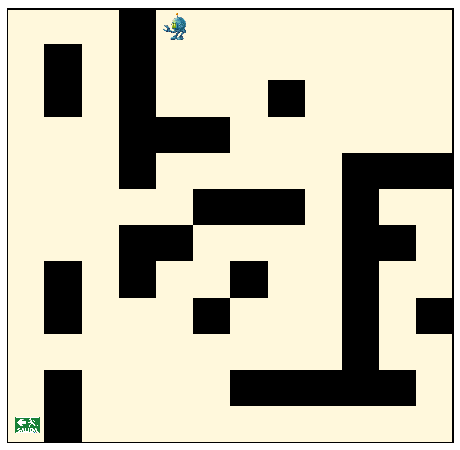

Exception: ¡Tabla incompleta! No contempla el estado [True, False, True, False]

In [15]:
# Create environment
lab = Laberinto()
# Create agent
agent = TableDriven()
agent.tabla = tabla
# Create episode
episodio = utils.Episode(environment=lab,\
        agent=agent,\
        model_name='Tabla',\
        num_rounds=15)
# Visualize
episodio.renderize()

El error `¡Tabla incompleta! No contempla el estado [True, False, True, False]` ocurre porque la tabla no tiene ninguna fila para el percepto `(True, False, True, False)` y entonces no puede determinar ninguna acción a tomar. ¡Observe que el agente no sabe qué acción tomar en ninguna situación cuando hay un muro enfrente! 

<a class="anchor" id="ej1"></a>**Ejercicio 1:** 

([Próximo ejercicio](#ej2))

El agente llega hasta que se topa con un muro y no sabe qué hacer. Extienda la tabla anterior para incluir las líneas que determinan que "si el frente y el flanco derecho están bloqueados y el flanco izquierdo no está bloqueado, voltear a la izquierda".

Visualice el funcionamiento del agente para comprobar su respuesta.

In [17]:
tabla = {
    # Si el frente no está bloqueado y el flanco derecho está
    # bloqueado, avanzar una casilla
    (False, True, True, True):['adelante'],
    (False, True, True, False):['adelante'],
    (False, False, True, True):['adelante'],
    (False, False, True, False):['adelante'],
    #si el frente y el flanco derecho están bloqueados y el flanco izquierdo no está bloqueado, voltear a la izquierda"
    (True, False, True, False):['voltearIzquierda'],
    (True, False, True, True):['voltearIzquierda']
}

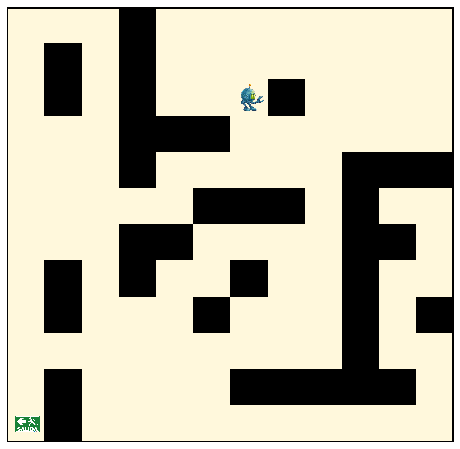

Exception: ¡Tabla incompleta! No contempla el estado [True, False, False, False]

In [18]:
# Create environment
lab = Laberinto()
# Create agent
agent = TableDriven()
agent.tabla = tabla
# Create episode
episodio = utils.Episode(environment=lab,\
        agent=agent,\
        model_name='Tabla',\
        num_rounds=15)
# Visualize
episodio.renderize()

<a class="anchor" id="ej2"></a>**Ejercicio 2:** 

([Anterior ejercicio](#ej1)) ([Próximo ejercicio](#ej3))

En la tabla falta incluir instrucciones que digan que "si el flanco derecho no está bloqueado, voltear a la derecha y avanzar una casilla". Extienda la tabla del ejercicio 2 para incluir las líneas que implementan esta regla. Visualice el funcionamiento del agente comenzando desde la casilla $(11,11)$.

**Nota:** cambie el parámetro `num_rounds` del episodio a 70.

In [56]:
tabla = {
    # Si el frente no está bloqueado y el flanco derecho está
    # bloqueado, avanzar una casilla
    (False, True, True, True):['adelante'],
    (False, True, True, False):['adelante'],
    (False, False, True, True):['adelante'],
    (False, False, True, False):['adelante'],
    #si el frente y el flanco derecho están bloqueados y el flanco izquierdo no está bloqueado, voltear a la izquierda"
    (True, False, True, False):['voltearIzquierda'],
    (True, False, True, True):['voltearIzquierda'],
    (True, False, False, False):['voltearIzquierda'],
    #si el flanco derecho no está bloqueado, voltear a la derecha y avanzar una casilla".
    (False, False, False, False):['voltearDerecha','adelante'],
    (True, False, False, False):['voltearDerecha','adelante'],
    (False, True, False, False):['voltearDerecha','adelante'],
    (False, False, False, True):['voltearDerecha','adelante'],
    (True, True, False, False):['voltearDerecha','adelante'],
    (True, False, False, True):['voltearDerecha','adelante'],
    (True, True, False, False):['voltearDerecha','adelante'],
    (True, True, False, True):['voltearDerecha','adelante'],
}

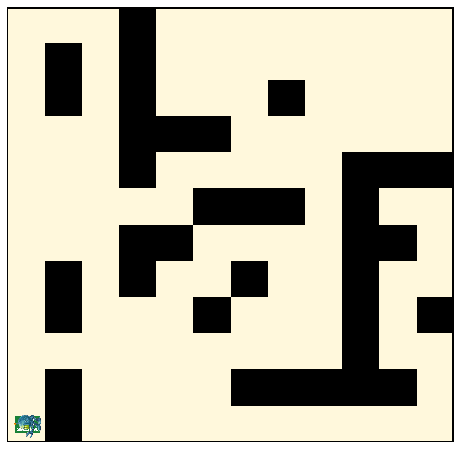

In [57]:
# Create environment
lab = Laberinto()
# Create agent
agent = TableDriven()
agent.tabla = tabla
# Create episode
episodio = utils.Episode(environment=lab,\
        agent=agent,\
        model_name='Tabla',\
        num_rounds=70)
# Visualize
episodio.renderize()

<a class="anchor" id="ej3"></a>**Ejercicio 3:** 

([Anterior ejercicio](#ej2)) ([Próximo ejercicio](#ej4))

* ¿Qué pasa cuando el agente comienza en la casilla $(6,3)$? Describa el comportamiento del agente y explique si el programa de agente resulta adecuado o no para este caso.

* ¿Qué pasa cuando el agente comienza en la casilla $(7,3)$? Describa el comportamiento del agente y explique si el programa de agente resulta adecuado o no para este caso.

---

## Un agente de reflejo simple <a class="anchor" id="agenteSR"></a>

([Volver al inicio](#inicio))

El proceso de escribir una tabla es bastante dispendioso, pues hay que considerar una gran cantidad de combinaciones de perceptos de los sensores. Un tipo de agente de nivel un poco más elevado que resuelve esta situación son los agentes de reflejo simple. El programa de este tipo de agentes está basado en relgas de condición-acción, las cuales relacionan condiciones sobre los sensores y las acciones. Al considerar condiciones en lugar de combinaciones de perceptos, la escritura es más eficiente.

A continuación presentamos una posible implementación de un agente de reflejo simple para el problema del laberinto, implementado en la clase `RuleBased` del módulo `agentes`.

In [58]:
# state[0]  =>  sensor forntal
# state[1]  =>  sensor izquierdo
# state[2]  =>  sensor derecho
# state[3]  =>  sensor trasero
reglas = {
    # Si el frente no está bloqueado y el flanco derecho está
    # bloqueado, avanzar una casilla
    'not state[0] and state[2]': ['adelante'],
    'state[0] and state[2] and not state[1]':['voltearIzquierda'] ,
     
}

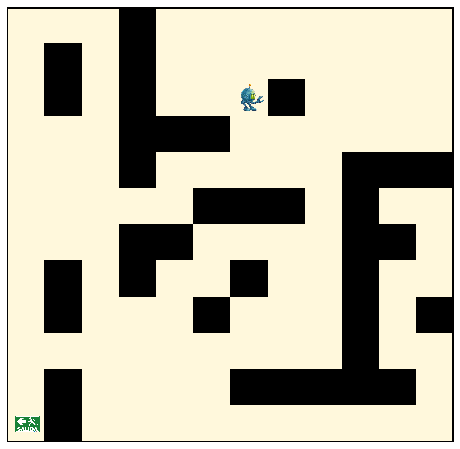

Exception: ¡Plan vacío! Revisar reglas en estado [True, False, False, False]

In [59]:
# Create environment
lab = Laberinto()
# Create agent
agent = RuleBased()
agent.reglas = reglas
# Create episode
episodio = utils.Episode(environment=lab,\
        agent=agent,\
        model_name='Reglas',\
        num_rounds=70)
# Visualize
episodio.renderize()

El error `¡Plan vacío! Revisar reglas en estado [True, False, True, False]` ocurre porque el programa aún no está equipado para dar una decisión cuando haya un muro enfrente.

<a class="anchor" id="ej4"></a>**Ejercicio 4:** 

([Anterior ejercicio](#ej3)) ([Próximo ejercicio](#ej5))

Extienda el programa de agente anterior para implementar las reglas condición-acción siguientes:

* Si el frente y el flanco derecho están bloqueados pero el flanco izquierdo no está bloqueado, voltear a la izquierda.
* Si el flanco derecho no está bloqueado, voltear a la derecha y avanzar una casilla.
* Si solo la casilla trasera no está bloqueada, voltear dos veces a la izquierda y avanzar una casilla.

Visualice el funcionamiento del agente desde la casilla $(11,11)$.

In [65]:
# state[0]  =>  sensor forntal
# state[1]  =>  sensor izquierdo
# state[2]  =>  sensor derecho
# state[3]  =>  sensor trasero
reglas = {
    # Si el frente no está bloqueado y el flanco derecho está
    # bloqueado, avanzar una casilla
    'not state[0] and state[2]': ['adelante'],
    'state[0] and state[2] and not state[1]':['voltearIzquierda'] ,
    'not state[2]':['voltearDerecha','adelante'],
    'not state[3] and state[0] and state[1] and state[2]': ['voltearIzquierda','voltearIzquierda']
     
}

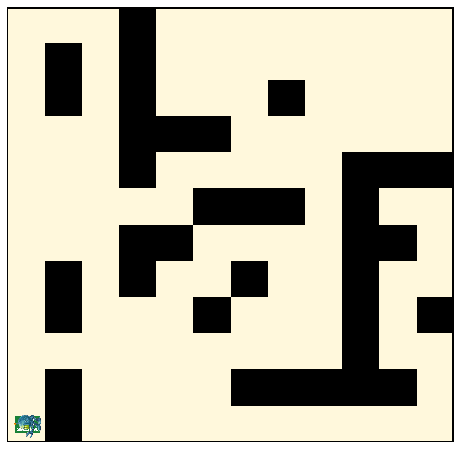

In [66]:
# Create environment
lab = Laberinto()
# Create agent
agent = RuleBased()
agent.reglas = reglas
# Create episode
episodio = utils.Episode(environment=lab,\
        agent=agent,\
        model_name='Reglas',\
        num_rounds=70)
# Visualize
episodio.renderize()

## Pruebas de desempeño <a class="anchor" id="pruebas"></a>

([Volver al inicio](#inicio))

Vamos a evaluar el desempeño de un solo agente respecto a qué tan rápido encuentra la salida y qué proporción de veces encuentra la salida. Luego compararemos el desempeño de dos agentes respecto a estas medidas.

**Evaluación de un agente**

En la clase `Experiment` del módulo `utils` tenemos el método `run_experiment()`, el cual nos sirve para simular varios episodios. En cada episodio el agente inicia en un lugar distinto del laberinto. Esto se logra cambiando a `True` el parámetro de inicialización de la clase `Laberinto`.

Corra varias veces la siguiente celda para comprobar que el agente comienza en distintas casillas cada vez:

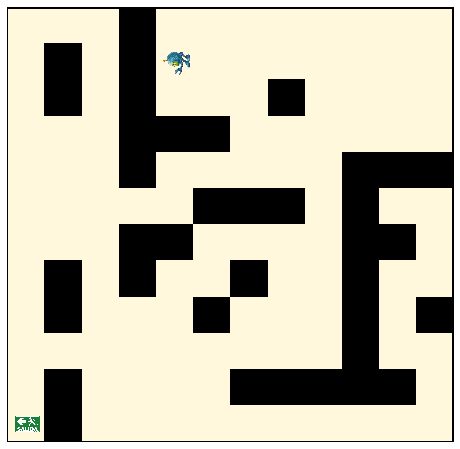

In [67]:
# Create environment
lab = Laberinto(aleatorio=True)
lab.render()

Ahora correremos la simulación. Nuestros parámetros serán un máximo de 300 rondas por cada episodio y correremos 100 episodios.

Observe que vamos a obtener un error del agente que tendremos que atender:

Testing agents over environment: 100%|███████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.50it/s]


Average sum of rewards:
 model
Reglas   -184.05
Name: reward, dtype: float64

Success percentage:
 model
Reglas    46.0
Name: done, dtype: float64


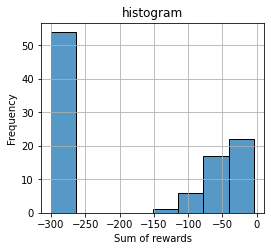

In [68]:
# Create experiment
exp = utils.Experiment(num_rounds=300, \
                       num_episodes=100)
# Create and load environment
lab = Laberinto(aleatorio=True)
exp.load_env(lab, "laberinto")
# Create list of agents
agent_rules = RuleBased()
agent_rules.reglas = reglas
agents_list = [agent_rules]
names = ['Reglas']
# Run the experiment
exp.run_experiment(agents=agents_list, \
                   names=names, \
                   measures=['histogram'])

El histograma nos muestra una columna muy alta para valores de -300 en la variable de recompensa total (sum of rewards), y otras columnas más pequeñas para valores más cercanos a 0. Observe que la recompensa total es igual al número de pasos que da el agente en el laberinto. Los resultados numéricos que arroja la celda anterior incluyen el promedio de este número de pasos. Observe también que el porcentaje de episodios en los cuales el entorno finaliza antes de las 300 rondas se presenta como el porcentaje de éxito. 

**Comparación de varios agentes**

Usaremos el método `run_experiment()` con una lista de varios agentes. El entorno se corre para cada uno de los agentes y se guardan los desempeños, para finalmente presentar los resultados de manera gráfica y tabular.

En el siguiente ejemplo compararemos el agente aleatorio y el basado en reglas:

Testing agents over environment: 100%|███████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.32s/it]


Average sum of rewards:
 model
Aleatorio   -288.55
Reglas      -182.23
Name: reward, dtype: float64

Success percentage:
 model
Aleatorio    11.0
Reglas       49.0
Name: done, dtype: float64


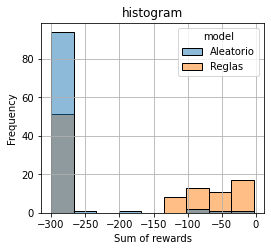

In [69]:
# Create experiment
exp = utils.Experiment(num_rounds=300, \
                       num_episodes=100)
# Create and load environment
# exp.load_test_suite("./testsuite_laberinto.json")
lab = Laberinto(aleatorio=True)
exp.load_env(lab, "laberinto")
# Create list of agents
agent_random = Random()
agent_rules = RuleBased()
agent_rules.reglas = reglas
agents_list = [agent_random, agent_rules]
names = ['Aleatorio', 'Reglas']
# Run the experiment
exp.run_experiment(agents=agents_list, \
                   names=names, \
                   measures=['histogram'])

El agente basado en reglas tiene un mejor desempeño que el agente aleatorio. Observe que la recompensa promedio del agente basado en reglas es -188, superior a -271 del agente aleatorio. Adicionalmente, el porcentaje de éxito del primero es 47%, mucho mayor que 14% del aleatorio. 

---

<a class="anchor" id="ej5"></a>**Ejercicio 5:** 

([Anterior ejercicio](#ej4)) ([Próximo ejercicio](#ej6))

Compare el desempeño de los agentes dirigido por tabla y basado en reglas. Comente los resultados del histograma.

Testing agents over environment: 100%|███████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.14s/it]


Average sum of rewards:
 model
Reglas   -128.99
tabla    -286.17
Name: reward, dtype: float64

Success percentage:
 model
Reglas    77.0
tabla     10.0
Name: done, dtype: float64


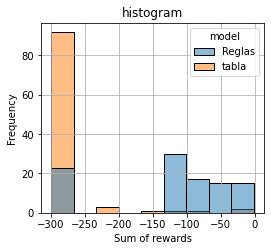

In [76]:
# Create experiment
exp = utils.Experiment(num_rounds=300, \
                       num_episodes=100)
# Create and load environment
# exp.load_test_suite("./testsuite_laberinto.json")
lab = Laberinto(aleatorio=True)
exp.load_env(lab, "laberinto")
# Create list of agents
agent_table = TableDriven()
agent_table.reglas = tabla
agent_rules = RuleBased()
agent_rules.reglas = reglas
agents_list = [agent_random, agent_rules]
names = ['tabla', 'Reglas']
# Run the experiment
exp.run_experiment(agents=agents_list, \
                   names=names, \
                   measures=['histogram'])

<a class="anchor" id="ej6"></a>**Ejercicio 6:** 

([Anterior ejercicio](#ej5))

1. Modifique el agente basado en reglas para implementar las siguientes reglas:
    * Si el frente no está bloqueado, avanzar una casilla.
    * Si el frente está bloqueado y el flanco derecho no está bloqueado, voltear a la derecha y avanzar una casilla.
    * Si el frente y el flanco derecho están bloqueados y el flanco izquierdo no está bloqueado, voltear a la izquierda.
    * Si solo la espalda no está bloquead, voltear a la izquierda dos veces y avanzar una casilla.

2. Compare y comente el desempeño de los dos agentes basados en reglas.

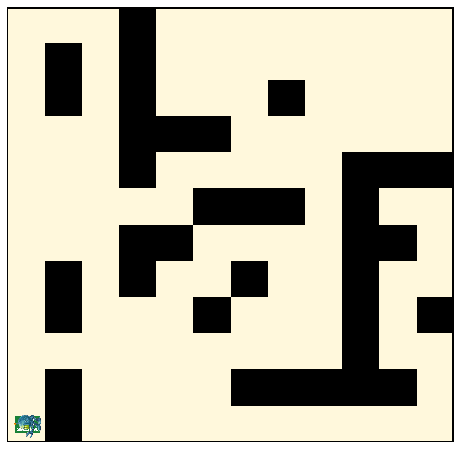

In [75]:
# state[0]  =>  sensor forntal
# state[1]  =>  sensor izquierdo
# state[2]  =>  sensor derecho
# state[3]  =>  sensor trasero
reglas = {
    # Si el frente no está bloqueado y el flanco derecho está
    # bloqueado, avanzar una casilla
    'not state[0]': ['adelante'],
    'state[0] and not state[2] ':['voltearDerecha','adelante'] ,
    'state[0] and state[2] and not state[1]':['voltearIzquierda'],
    'state[0] and state[1] and state[2] and not state[3]': ['voltearIzquierda','voltearIzquierda','adelante']
     
}
# Create environment
lab = Laberinto()
# Create agent
agent = RuleBased()
agent.reglas = reglas
# Create episode
episodio = utils.Episode(environment=lab,\
        agent=agent,\
        model_name='Reglas',\
        num_rounds=300)
# Visualize
episodio.renderize()

## En este notebook usted aprendió

* Los detalles de la implementación de programas de agente dirigido por tabla y de reflejo simple.
* Realizar pruebas de desempeño a los agentes.
